In [2]:
# Loading your IBM Quantum account(s)
from qiskit import IBMQ
IBMQ.save_account('263686330c40a9a6c084aaa9e789d7bf7485836d58262dc7fbfd099926b50fd2c496c5d582d8ebd70eef5fa3bb1b55c4795dc6646b5dcf5f879ef96c609d1d7b')

configrc.store_credentials:WARNING:2021-10-04 12:10:05,604: Credentials already present. Set overwrite=True to overwrite.


In [8]:
# import modules
import numpy as np
import math
import copy
import matplotlib
from datetime import datetime, date
from qiskit.quantum_info import *
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, execute
from qiskit.providers.aer import AerSimulator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import *
from qiskit.providers.aer import AerError
from qiskit.test.mock import FakeMelbourne

from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer

from itertools import groupby, permutations, product

In [9]:
# read in functions
def encode_logical_qubit(qc):
    #qc.z(p[0]) #(Achtung, ich muss nachrechnen ob ich das hier brauche)
    qc.h(p[1])
    qc.cx(p[1],p[0])
    qc.cz(p[1],p[2])
    qc.cz(p[1],p[4])
    
    qc.h(p[4])
    qc.cx(p[4],p[0])
    qc.cz(p[4],p[1])
    qc.cz(p[4],p[3])
    
    qc.h(p[3])
    qc.cx(p[3],p[4])
    qc.cz(p[3],p[2])
    qc.cz(p[3],p[0])
    
    qc.h(p[2])
    qc.cx(p[2],p[3])
    qc.cz(p[2],p[1])
    qc.cz(p[2],p[4])
    qc.barrier()
    
def stabilizer_measurements(qc):
    
    # define custom gates for noise specification
    cx_op = Operator([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])
    cz_op = Operator([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, -1]])
    h_op = Operator([[1/np.sqrt(2),1/np.sqrt(2)],
                    [1/np.sqrt(2),-1/np.sqrt(2)]])
    
    qc.unitary(h_op,[a], label='noisy_h')
    
    qc.unitary(cz_op,[a[0],p[4]], label='noisy_cz')
    qc.unitary(cx_op,[a[0],p[3]], label='noisy_cx')
    qc.unitary(cx_op,[a[0],p[2]], label='test_cx')
    qc.unitary(cz_op,[a[0],p[1]], label='test_cz')
    qc.barrier()
    
    qc.unitary(cx_op,[a[1],p[4]], label='test_cx')
    qc.unitary(cx_op,[a[1],p[3]], label='noisy_cx')
    qc.unitary(cz_op,[a[1],p[2]], label='test_cz')
    qc.unitary(cz_op,[a[1],p[0]], label='noisy_cz')
    qc.barrier()
    
    qc.unitary(cx_op,[a[2],p[4]], label='noisy_cx')
    qc.unitary(cz_op,[a[2],p[3]], label='test_cz')
    qc.unitary(cz_op,[a[2],p[1]], label='noisy_cz')
    qc.unitary(cx_op,[a[2],p[0]], label='test_cx')
    qc.barrier()
    
    qc.unitary(cz_op,[a[3],p[4]], label='test_cz')
    qc.unitary(cz_op,[a[3],p[2]], label='noisy_cz')
    qc.unitary(cx_op,[a[3],p[1]], label='test_cx')
    qc.unitary(cx_op,[a[3],p[0]], label='noisy_cx')
    qc.barrier()

    #qc.h(a)
    qc.unitary(h_op,[a], label='noisy_h')

    qc.measure(a,c)

    
def apply_correction(qc):
    qc.z(p[0]).c_if(c,12) 
    qc.z(p[1]).c_if(c,8)
    qc.z(p[2]).c_if(c,1)
    qc.z(p[3]).c_if(c,3)
    qc.z(p[4]).c_if(c,6)
    
    qc.x(p[0]).c_if(c,2)    
    qc.x(p[1]).c_if(c,5)
    qc.x(p[2]).c_if(c,10)
    qc.x(p[3]).c_if(c,4)
    qc.x(p[4]).c_if(c,9)

    qc.y(p[0]).c_if(c,14)    
    qc.y(p[1]).c_if(c,13)
    qc.y(p[2]).c_if(c,11)
    qc.y(p[3]).c_if(c,7)
    qc.y(p[4]).c_if(c,15)
    
def decode_logical_state(qc):
    # decode logical state
    qc.barrier()
    qc.cz(p[2],p[4])
    qc.cz(p[2],p[1])
    qc.cx(p[2],p[3])

    qc.h(p[2])

    qc.cz(p[3],p[0])
    qc.cz(p[3],p[2])
    qc.cx(p[3],p[4])

    qc.h(p[3])

    qc.cx(p[4],p[0])
    qc.cz(p[4],p[1])
    qc.cz(p[4],p[3])

    qc.h(p[4])

    qc.cx(p[1],p[0])
    qc.cz(p[1],p[2])
    qc.cz(p[1],p[4])

    #qc.z(p[0]) #(Achtung, ich muss nachrechnen ob ich das hier brauche)
    qc.h(p[1])
    

In [10]:
    
def my_measurement(qc,noise,my_shots,p_error):
    try:
        if noise=="FakeMelbourne":
            # transpile for mocked noisy device
            device_backend = FakeMelbourne()
            simulator = AerSimulator.from_backend(device_backend)

            # Transpile the circuit for the noisy basis gates
            tqc = transpile(qc, simulator)

        elif noise=="PauliApprox":
            my_noise_model = build_noise_model(p_error=p_error)
            simulator = AerSimulator(noise_model=my_noise_model)
            tqc = transpile(qc, simulator, optimization_level=0)
        
        elif noise=="NoNoise":
            # Transpile for ideal simulator
            simulator = Aer.get_backend('aer_simulator')
            tqc = transpile(qc, simulator)
        
        result = simulator.run(tqc, shots=my_shots, memory=True).result()
        return result, tqc

    except AerError as e:
        print(e)

# Check pure state fidelity
def fidelity_check(psi1, psi2):
    fidelity = state_fidelity(psi1,psi2)
    if (0.95 <= fidelity.real <= 1.05) and (-0.01 <= fidelity.imag <= 0.01):
        return True
    return False

In [11]:
def build_noise_model(p_error):
    # build noise for preparation and measurement
    # define error probabilities
    p_prep_bit = p_error
    p_prep_phase = p_error
    p_meas_bit = p_error
    p_meas_phase = p_error

    p_gate = p_error
    p_gate_am = p_error
    p_gate_ph = p_error
    p_depol = p_error

    p_am = p_error
    p_ph = p_error

    # build preparation noise
    prep_bit_flip = pauli_error([('X', p_prep_bit),('I', 1 - p_prep_bit)])
    prep_phase_flip = pauli_error([('Z', p_prep_phase),('I', 1 - p_prep_phase)])
    prep_bitphase_flip = prep_bit_flip.compose(prep_phase_flip) 

    # build measurement noise
    meas_bit_flip = pauli_error([('X', p_meas_bit),('I', 1 - p_meas_bit)])
    meas_phase_flip = pauli_error([('Z', p_meas_phase),('I', 1 - p_meas_phase)])
    meas_bitphase_flip = meas_bit_flip.compose(meas_phase_flip)
    
    # Option: bit-phase-flip noise for all single- and two-qubit gates
    error_gateX = pauli_error([('X', p_gate), ('I', 1 - p_gate)])
    error_gateY = pauli_error([('Y', p_gate), ('I', 1 - p_gate)])
    error_gateZ = pauli_error([('Z', p_gate), ('I', 1 - p_gate)])
    no_error = pauli_error([('I', 1.0)])
    #error_gate2 = error_gate1.tensor(error_gate1)

    # build single qubit depolarizing channel
    # acts on n Qubits using the .tensor() method
    # but note that this means that errors act independently on single qubit
    depol_error1 = pauli_error([('X', p_error/4), ('Y', p_error/4), ('Z', p_error/4), ('I', 1 - (3*p_error)/4)])
    depol_error2 = depol_error1.tensor(depol_error1)
    test_error = depol_error1.tensor(no_error)
    depol1 = depolarizing_error(p_depol, 1)
    
    param_q0 = p_error  # damping parameter for qubit-0
    param_q1 = p_error   # damping parameter for qubit-1

    qerror_q0 = amplitude_damping_error(param_q0)
    qerror_q1 = amplitude_damping_error(param_q1)
    cgate_error = qerror_q1.tensor(qerror_q0)

    # example for phase-amplitude-damping-error (Kraus channel, CPTP)
    #am_deph_error1 = phase_amplitude_damping_error(p_am, p_ph)
    #error_pham_dp2 = error_pham_dp1.tensor(error_pham_dp1)

    # self-build Pauli channel approximating amplitude-phase-damping
    # calculate prob from T1,T2,t (params from Wootton)
    t = 0.001*0.25
    T1 = 1000
    T2 = 1
    p_error_xy = (1-np.exp(-t/T1))/4
    p_error_z = (1-np.exp(-t/T2))/2 - p_error_xy
    p_error_id = 1 - 2*p_error_xy - p_error_z
    am_deph_error1 = pauli_error([('X', p_error_xy), ('Y', p_error_xy), ('Z', p_error_z), ('I', p_error_id)])
    
    # Create an empty noise model
    my_noise_model = NoiseModel()

    
    # add arbitrary unitary operation in order to specify noise model
    #my_noise_model.add_basis_gates(['unitary'])
    #my_noise_model.add_quantum_error(depol_error2, 'test_cx', [5,3])
    
    #my_noise_model.add_all_qubit_quantum_error(test_error,'test_cx')
    #my_noise_model.add_all_qubit_quantum_error(test_error, 'test_cz')
    #my_noise_model.add_quantum_error(depol_error1, ["h"])
    
    #my_noise_model.add_all_qubit_quantum_error(depol_error1, ['id'])
    #my_noise_model.add_quantum_error(error_gateX, ['id'], [0])
    
    my_noise_model.add_quantum_error(depol1, ['id'], [4])
    my_noise_model.add_quantum_error(depol1, ['id'], [1])
    my_noise_model.add_quantum_error(depol1, ['id'], [2])
    my_noise_model.add_quantum_error(depol1, ['id'], [3])
    my_noise_model.add_quantum_error(depol1, ['id'], [0])
    
    #my_noise_model.add_all_qubit_quantum_error(depol1, ['id'])

    





    # add noise
    # Woottons noise model:
    #my_noise_model.add_all_qubit_quantum_error(prep_bitphase_flip, "reset")
    #my_noise_model.add_all_qubit_quantum_error(meas_bitphase_flip, "measure")
    #my_noise_model.add_all_qubit_quantum_error(depol_error2, ["cx","cz"])
    #my_noise_model.add_all_qubit_quantum_error(am_deph_error1, ["id"])
    
    #for k in range(5,9):
        #my_noise_model.add_quantum_error(depol_error2, ["cx","cz"], [0,k])
    
    #my_noise_model.add_quantum_error(depol_error2, ["cx"], [5,3])
    
    #my_noise_model.add_quantum_error(error_gateX, ['x'], [0])
    #for k in range(5):
    #    my_noise_model.add_quantum_error(depol_error1, ['id'], [k])
    
    print(my_noise_model)
    # my_noise_model.add_quantum_error(am_deph_error1, ["x"], [1])

    
    return my_noise_model

In [12]:
def execute_5QubitCode(noise, p_error, shots):
    qc = QuantumCircuit(p,a,c,res)
    
    # set up pure initial state (optional)
    #y_initial_state = [1/np.sqrt(2), 1/np.sqrt(2)]
    #qc.initialize(y_initial_state, p[0])
    
    # set up mixed initial state
    #mixedstate = np.zeros((512,512))
    #mixedstate[0][0] = 0.5
    #mixedstate[1][1] = 0.5
    #rho = [[0.95+0.j, 0.0+0.0j],[0.0+0.0j,0.05+0.j]]
    #qc.set_density_matrix(mixedstate)

    # save inital state
    #qc.save_density_matrix(label='init_dmatrix')
    #qc.save_density_matrix([p[0]], label='init_dmatrix')
    qc.save_density_matrix([p[0]], label = 'single_init_dmatrix')

    # encode logical qubit
    #qc.id(p[2])
    encode_logical_qubit(qc)
    qc.save_density_matrix(p, label='init_dmatrix')

    # try single errors
    qc.id(p)
    #qc.id(p[4])
    #qc.id(p[1])
    #qc.id(p[2])
    #qc.id(p[3])
    #qc.id(p[0])
    #qc.id(a)
    
    #cx_op = Operator([[1, 0, 0, 0],
    #                 [0, 0, 0, 1],
    #                 [0, 0, 1, 0],
    #                 [0, 1, 0, 0]])
    #qc.unitary(cx_op,[p[1],p[3]], label='test_cx')
    
    #id_op = Operator([[1, 0, 0, 0],
    #                  [0, 1, 0, 0],
    #                  [0, 0, 1, 0],
    #                  [0, 0, 0, 1]])
    #qc.unitary(id_op,[p[0],p[1]], label='id_test')
    
    #if np.random.binomial(1, p_error):
    #    qc.x(1)

    # encode stabilizers
    stabilizer_measurements(qc)
    #display(qc.draw())
    
    #########################################################################################

    # Das hier kommentiere ich aus und ersetze es durch die konditionellen Quantumoperationen
    # measure
    # result, tqc = my_measurement(qc=qc,noise=noise,my_shots=shots,p_error=p_error)
    # counts = result.get_counts(tqc)
    # print(counts)
    #stab_result = list(counts.keys())[0]

    # get corresponding correction operation
    #op,loc = correction_dict[list(counts.keys())[0]]

    # apply correction
    #correction(qc=qc,op=op,loc=loc)

    # repeat stabilizer measurement (only to check if we returned to code space successfully)
    #qc.reset(a)
    #encode_stabilizer_measurements(qc)
    #result, tqc = my_measurement(qc=qc,noise=noise,my_shots=1,p_error=p_error)
    #counts = result.get_counts(tqc)
    #print("corr_result = ", counts)
    
    #########################################################################################

    # decode logical state and set up measurement
    apply_correction(qc)
    qc.reset(a)
    qc.save_density_matrix(p, label = 'corr_dmatrix')
    
    decode_logical_state(qc)
    qc.save_density_matrix([p[0]], label = 'decoded_dmatrix')
    #qc.reset(a)
    #qc.save_density_matrix([p[0]], label = 'corr_dmatrix')
    #qc.save_density_matrix(label = 'corr_dmatrix')
    #qc.cx(p,a)
    #qc.measure(p,c)
    qc.cx(p[0],a[0])
    qc.measure(a[0],res)
    #display(qc.draw())
    #display(qc.draw())
    #qc.measure(a,c)
    #dag = circuit_to_dag(qc)
    #display(dag_drawer(dag))

    # measure logical state
    result, tqc = my_measurement(qc=qc,noise=noise,my_shots=shots,p_error=p_error)
    #display(tqc.draw())
    #tdag = circuit_to_dag(tqc)
    #display(dag_drawer(tdag))
    #display(plot_circuit_layout(tqc, device_backend))
    counts = result.get_counts(tqc)
    print(counts)
    
    if not (noise=="NoNoise"):
        # groupby from itertools, returns iterators: k for grouping key, g for items in that group
        grouped_counts = {k:(dict((el[0].split(' ')[1],el[1]) for el in g)) for k, g in groupby(sorted(counts.items()), lambda s: s[0].split(' ')[0])}
        for i in range(2):
            if not (str(i) in grouped_counts.keys()):
                grouped_counts[str(i)] = {}
        copy_grouped_counts = copy.deepcopy(grouped_counts)
        syndromes = [''.join(syn) for syn in product('01', repeat=4)]

        # füge 0-Wkt für nicht vorhandene syndrome ein
        for syn in syndromes:
            for i in range(2):
                if not (str(i) in grouped_counts.keys()):
                    grouped_counts[str(i)] = {}
                if not (syn in grouped_counts[str(i)].keys()):
                    grouped_counts[str(i)][syn] = 0

        # create array containing syndrome probabilities
        syn_probs = {syn: grouped_counts['0'][syn]+grouped_counts['1'][syn] for syn in syndromes}

        error_rate = sum([grouped_counts['1'][syn]/shots for syn in syndromes])
        success_rate = sum([grouped_counts['0'][syn]/shots for syn in syndromes])
        #lookup_table = {syn: max(grouped_counts['0'][syn],grouped_counts['1'][syn]) for syn in syndromes}
        
        lookup_table = {}
        for syn in syndromes:
            if ((syn in copy_grouped_counts['0'].keys()) and (syn in copy_grouped_counts['1'].keys())):
                
                lookup_table[syn] = max(grouped_counts['0'][syn],grouped_counts['1'][syn])
            else:
                lookup_table[syn] = grouped_counts['0'][syn]

        lookup_error = 1-sum(lookup_table.values())/shots

        print('physical error rate', p_error)
        print('calculated lookup_error', lookup_error)                                             
        print('calculated error_rate = %f' %error_rate, 'calc success_rate = %f' %success_rate)
        print('total prob is conserved?', error_rate+success_rate)

    # print out results
    init_dmatrix = result.data()['init_dmatrix']
    corr_dmatrix = result.data()['corr_dmatrix']
    init2_dmatrix = result.data()['single_init_dmatrix']
    corr2_dmatrix = result.data()['decoded_dmatrix']
    
    fid = state_fidelity(init_dmatrix, corr_dmatrix)
    fid0 = state_fidelity(init2_dmatrix, corr2_dmatrix)


    print("fidelity = %f" % fid)
    print("single state fidelity = %f" % fid0)
    return([round(p_error,7),round(error_rate,7),round(lookup_error,7),round((1-fid),7), round((1-fid0),7)])
    
    #plot_bloch_multivector(psi)
    #print("stab_result=", stab_result)
    #print("correction operation: op= ", op, "qubit_nr= ", loc)

In [14]:
#############################################################
###################### main #################################
#############################################################

# params
device_backend = FakeMelbourne()


shots = 100
p_start = 0.01
p_error_end = 0.02
p_step = 0.01
# noise is either "NoNoise", "PauliApprox" or "FakeMelbourne" 
noise = "PauliApprox"

# set up registers
p = QuantumRegister(5,'p')
a = QuantumRegister(4,'a')
c = ClassicalRegister(4, 'c')
res = ClassicalRegister(1, 'res')

results = []
p_error = p_start
#time = datetime.now(tz=None)
#date = date.today()
with open(("errorrate_" + str(date.today()) + ".dat"), "a") as f:
    f.write("#physical error\t error rate\t lookup error rate\t 1-fidelity\t 1-decoded_fidelity\n")
    while p_error<=p_error_end:
        result_list = execute_5QubitCode(noise=noise, p_error=p_error, shots=shots)
        results.append(result_list)
        for el in result_list: f.write(str(el)+"\t")
        f.write("\n")
        p_error += p_step
    f.close()
aresults = np.array(results)

#while counter<=rounds:
    #print("round {0}".format(counter))
#    result_list = execute_5QubitCode(noise=noise, p_error=p_error, shots=shots)
#    counter += 1
#print("fidelity errors: {0} \t measurement errors: {1} \t total rounds: {2} \t error rate: {3} \n"\
#      .format(error_rate_fidelity, error_rate_measurement, counter-1,(error_rate_measurement/(counter-1)) ))

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [4]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [0])]
{'0 0000': 97, '0 1110': 1, '0 0010': 1, '0 0001': 1}
physical error rate 0.01
calculated lookup_error 0.0
calculated error_rate = 0.000000 calc success_rate = 1.000000
total prob is conserved? 1.0
fidelity = 1.000000
single state fidelity = 1.000000
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [4]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [0])]
{'0 0000': 95, '0 0110': 1, '0 1110': 1, '0 1010': 2, '0 1101': 1}
physical error rate 0.02
calculated lookup_error 0.0
calculated error_rate = 0.000000 calc success_rate = 1.000000
total prob is conserved? 1.0
fidelity = 1.000000
single state fidelity = 1.000000


Set up arbitrary density matrix, print it, manipulate entries:

In [ ]:
a = np.zeros((32,32))
a[0][0] = 0.5
a[1][1] = 0.5
print(a)

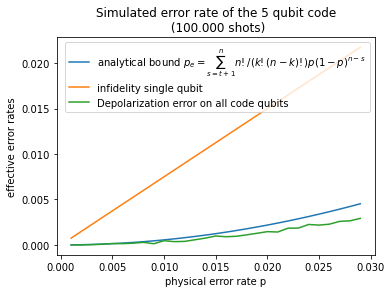

In [32]:
# analytische Abschätzung der Fehlerrate
p_start = 0.001
p_error_end = 0.03
p_step = 0.001

def calc_single_error_rate(p,n,t):
    errorrate = 0.0
    for i in range(t+1,n+1):
        errorrate += (np.power(p,i)*np.power((1-p),(n-i))*(np.math.factorial(n)/(np.math.factorial(i)*np.math.factorial(n-i))))
    return errorrate

def calc_upper_bound(p,n):
    return np.power(p,2)*(np.math.factorial(n)/(np.math.factorial(2)*np.math.factorial(n-2)))

# analytische Abschätzung
# Anzahl locations: n_1 = 5 => Fehler durch Dekohärenz der Code-Qubits, Operationen fehlerfrei
# n_2 = 
n_1=5
t=1
#x = np.arange(0.01,0.5,0.01)
x = np.arange(p_start,p_error_end,p_step)
#print(calc_single_error_rate(p=x,n=n_1,t=t))
#print(calc_upper_bound(p=x,n=n_1))

aresults = np.loadtxt('errorrate_2021-09-27 06:53:08.578109.dat')

plt.figure(figsize=(5.7,4.0))
plt.title('Simulated error rate of the 5 qubit code\n (100.000 shots)')
plt.xlabel('physical error rate p')
plt.ylabel('effective error rates')
plt.plot(x,calc_single_error_rate(p=((3*x)/4),n=n_1,t=t), label='analytical bound $p_e =\sum_{s=t+1}^{n} n!/(k!(n-k)!) p (1-p)^{n-s} $')
#plt.plot(x,calc_upper_bound(p=((3*x)/4),n=n_1), label='upper analytical bound')
plt.plot(x,((3*x)/4), label='infidelity single qubit')
plt.plot(aresults[:,0],aresults[:,1], label='Depolarization error on all code qubits')
#plt.plot(aresults[:,0],aresults[:,2], label='lookup table rate for same error')
plt.legend()
plt.show()


In [ ]:
single_error_rate = calc_single_error_rate(p=x,n=n_1,t=t)
upper_bound = calc_upper_bound(p=x,n=n_1)
with open(("analyticalrate.dat"), "w") as f:
    f.write("#physical error\t error rate \t upper bound error rate\n")
    for i in range(len(x)): 
        f.write(str(x[i])+"\t"+str(single_error_rate[i])+"\t"+str(upper_bound[i])+"\n")
    f.close()

In [8]:
# analytische Abschätzung der Fehlerrate
p_start = 0.1
p_error_end = 0.3
p_step = 0.1

def calc_single_error_rate(p,n,t):
    errorrate = 0.0
    for i in range(t+1,n+1):
        errorrate += (np.power(p,i)*np.power((1-p),(n-i))*(np.math.factorial(n)/(np.math.factorial(i)*np.math.factorial(n-i))))
    return errorrate

def calc_upper_bound(p,n):
    return np.power(p,2)*(np.math.factorial(n)/(np.math.factorial(2)*np.math.factorial(n-2)))

# analytische Abschätzung
# Anzahl locations: n_1 = 5 => Fehler durch Dekohärenz der Code-Qubits, Operationen fehlerfrei
# n_2 = 
n_1=5
t=1
#x = np.arange(0.01,0.5,0.01)
x = np.arange(p_start,p_error_end,p_step)
print(calc_single_error_rate(p=x,n=n_1,t=t))
print(calc_upper_bound(p=x,n=n_1))

[0.08146 0.26272]
[0.1 0.4]


In [ ]:
# write results to file:
time = datetime.now(tz=None)
date = date.today()
with open(("errorrate_" + str(date.today()) + ".txt"), "a") as f:
    f.write("syndrome\t measurement \t error\t rho_fidelity\t pure_fidelity\n")
    counter = 0
    while counter<rounds:
        result_list = execute_5QubitCode(noise=noise, p_error=p_error, shots=shots)
        for el in result_list: f.write(el+"\t")
        f.write("\n")
        counter += 1
    f.write("errors: {0} \t total_rounds: {1} \t error_rate: {2} \n".format(error_rate, counter,(error_rate/counter)))
    f.close()

In [ ]:
shots = 4
qr = QuantumRegister(2)
cr1 = ClassicalRegister(2)
#cr2 = ClassicalRegister(1)
cr3 = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr1)
qc.x(qr[1])
qc.measure(qr,cr1)
qc.x(qr[0]).c_if(cr1,2)
qc.measure(qr,cr1)
#qc.x(qr[1]).c_if(cr2, 0)
#qc.measure(qr,cr3)
display(qc.draw())


my_noise_model = build_noise_model(p_error=0.1)
simulator = AerSimulator(noise_model=None)
#simulator = Aer.get_backend('aer_simulator')
tqc = transpile(qc, simulator)

result = simulator.run(tqc,shots=shots,memory=True).result()
counts = result.get_counts()
counts

In [ ]:
    correction_dict = {
    "0000":("I",0), 0, pass
        
    "1100":("z",0), 12, 
    "1000":("z",1), 8
    '0001':('z',2), 1
    '0011':('z',3), 3
    '0110':('z',4), 6
        
    '0010':('x',0), 2
    '0101':('x',1), 5
    '1010':('x',2), 10
    '0100':('x',3), 4
    '1001':('x',4), 9
        
    '1110':('y',0), 14
    '1101':('y',1), 13
    '1011':('y',2), 11
    '0111':('y',3), 7
    '1111':('y',4), 15
    }
    

In [ ]:

    
    #syns = [grouped_counts[0][sy] for sy in syndromes]
    #print(syns)
    #syn_probs = zip(syndromes, [grouped_counts[0][sy] for sy in syndromes] )
    #print(syn_probs)
        
    #print(syndromes)
    #syndrom_probability = 
    
    #counts_success = [(el[0].split(' ')[1],el[1]) for el in grouped_counts[0]]
    #counts_failure = [(el[0].split(' ')[1],el[1]) for el in grouped_counts[1]]

In [ ]:
num_qubits = 1
#rho = qi.random_density_matrix(2 ** num_qubits, seed=100)
#print(rho)
rho = [[ 0.95+0.j, 0.0+0.0j], [0.0+0.0j,  0.05+0.j       ]]
circ = QuantumCircuit(num_qubits)
circ.set_density_matrix(rho)
circ.save_state()

In [ ]:
# Hier weiter: Reihenfolge des Inputs rausfinden!
qc_AB = QuantumCircuit(2)
#qc_AB.x(0)
my_initial_state = [np.sqrt(0.95), np.sqrt(0.05)]
qc_AB.initialize(my_initial_state, 0)
#qc_AB.h(0)
#qc_AB.cx(0,1)
qc_AB.draw()
psi_AB = qi.Statevector.from_instruction(qc_AB)
psi_AB.draw('latex', prefix='|\\psi_{AB}\\rangle = ')

In [ ]:
rho_AB = qi.DensityMatrix.from_instruction(qc_AB)
print(rho_AB)
rho_AB.draw('latex', prefix='\\rho_{AB} = ')